In [1]:
%matplotlib inline
import scipy.io
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.time import Time

In [2]:
def round_of_rating(number):
    return round(number * 2) / 2

In [3]:
tag=scipy.io.loadmat('/Users/cliu/Dropbox/Geolocation/projects/cod_zemeckis/tag_data/13_raw.mat',squeeze_me =False,struct_as_record=True)
tag=tag['tag']
dnum=tag['dnum'][0,0][:,0]
temp=tag['temp'][0,0][:,0]
depth=tag['depth'][0,0][:,0]
dnum=dnum-678942
idx=depth>20

# # downsample to 0.5m
# depth = np.array([round_of_rating(i) for i in depth])

data=pd.DataFrame({'dnum':dnum[idx],'temp':temp[idx],'depth':depth[idx]})
data['DATE']=Time(data.dnum,format='mjd',scale='utc').datetime
data['DATE']=pd.to_datetime(data['DATE'])
data = data.set_index('DATE')
data.index = data.index.round('S')

# # downsample to 30min
# index = pd.date_range(data.index[0], data.index[-1], freq='30T')
# data = data.reindex(index, method='ffill')

In [4]:
data['depth_change'] = abs(data['depth'].diff())

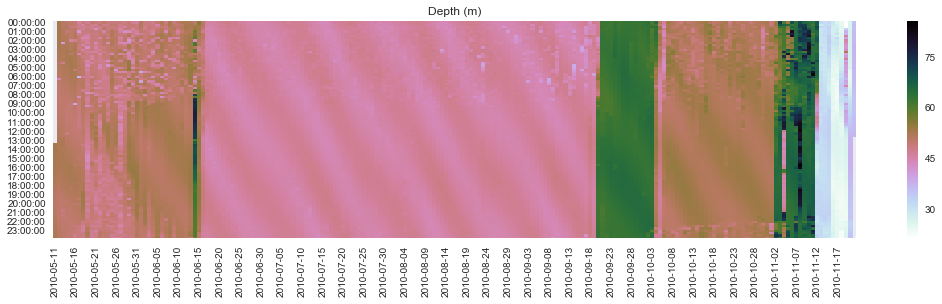

In [5]:
groups = data['depth'].groupby(pd.TimeGrouper('D'))
days = pd.DataFrame()
for name, group in groups:
    ts = pd.DataFrame({str(name.date()):group.values}, index=[val.time() for val in group.index])
    days = pd.concat([days, ts], axis=1)
plt.figure(figsize=(18, 4))
ax = sns.heatmap(days, cmap='cubehelix_r', xticklabels=5, yticklabels=4)
plt.title('Depth (m)')

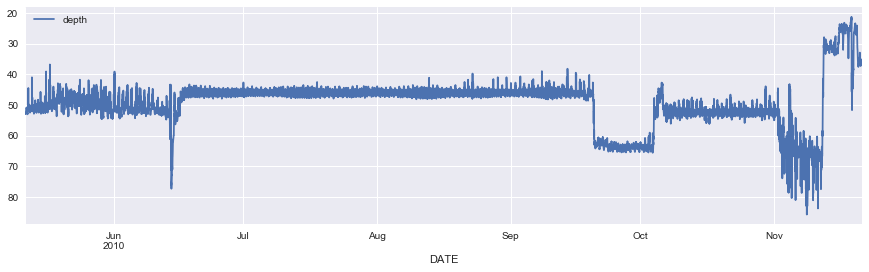

In [6]:
data.plot(y='depth', figsize=(15,4)).invert_yaxis()

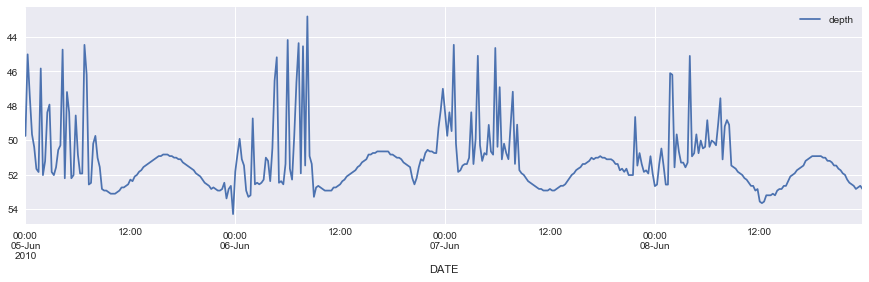

In [7]:
data['2010-Jun-5':'2010-Jun-8'].plot(y='depth', figsize=(15,4)).invert_yaxis()

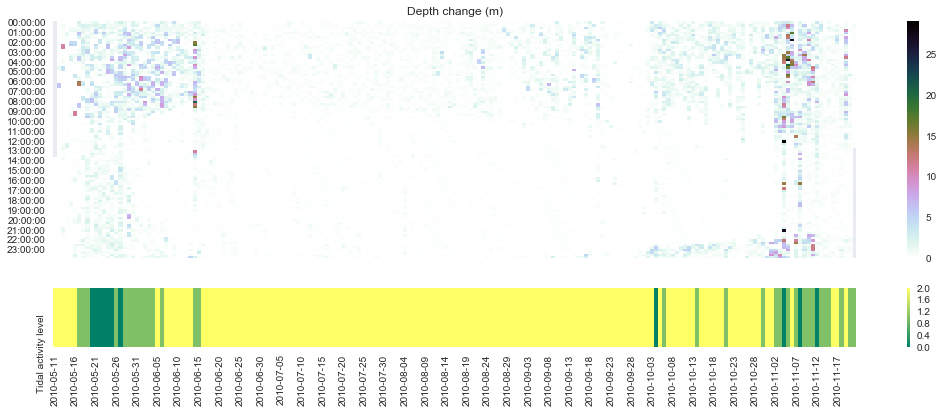

In [8]:
groups = data['depth_change'].groupby(pd.TimeGrouper('D'))
days = pd.DataFrame()
for name, group in groups:
    ts = pd.DataFrame({str(name.date()):group.values}, index=[val.time() for val in group.index])
    days = pd.concat([days, ts], axis=1)
fig = plt.figure(figsize=(18, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
# fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), nrows=2, sharex=True)

sns.heatmap(days, cmap='cubehelix_r', xticklabels=5, yticklabels=4, ax=ax1)
ax1.set_title('Depth change (m)')
plt.setp(ax1.get_xticklabels(), visible=False)

# plot tidal activity level
tagname=str(tag['fish_id'][0,0][0,0])+'_'+tag['tag_id'][0,0][0]
lv=scipy.io.loadmat('/Users/cliu/Dropbox/Geolocation/smast_geolocate/run_dtcod_hpcc_cscvr/ObsLh'+tagname+'.mat',squeeze_me =False,struct_as_record=True)
tide = lv['tide'][0]
df_tide = pd.DataFrame(index=days.columns, data={"Tidal activity level":tide})
sns.heatmap(df_tide.T, cmap='summer', xticklabels=5, ax=ax2)

In [9]:
depth_change_sum = data['depth_change'].resample('D').sum()
depth_change_sum.index = depth_change_sum.index.astype('str')
daily = pd.concat([df_tide, depth_change_sum], axis=1)

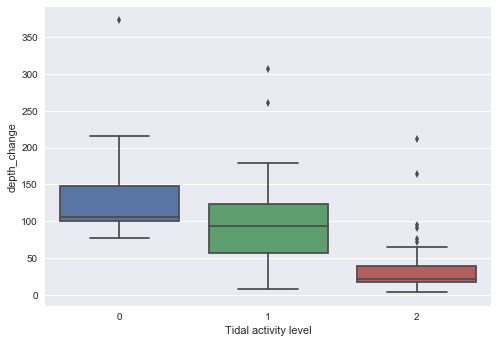

In [10]:
sns.boxplot(x='Tidal activity level', y='depth_change', data=daily)

Take thrid quatile of low activity depth change:

In [11]:
np.percentile(daily['depth_change'].loc[daily['Tidal activity level']==2], 50)

22.09974999999999

count    195.000000
mean      49.217690
std       52.513229
min        4.061000
25%       18.956000
50%       28.307400
75%       52.928600
max      372.329300
Name: depth_change, dtype: float64

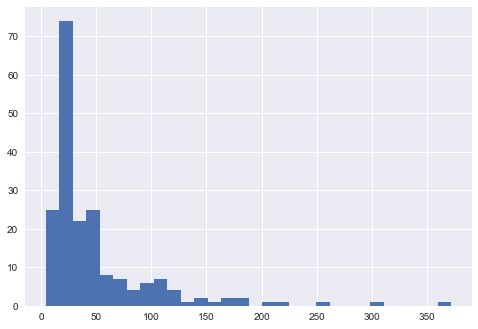

In [12]:
daily['depth_change'].hist(bins=30)
daily['depth_change'].describe()

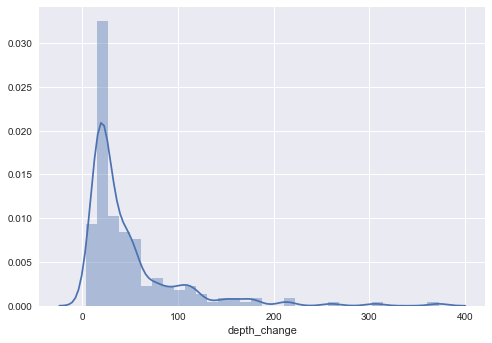

In [13]:
sns.distplot(daily['depth_change'])

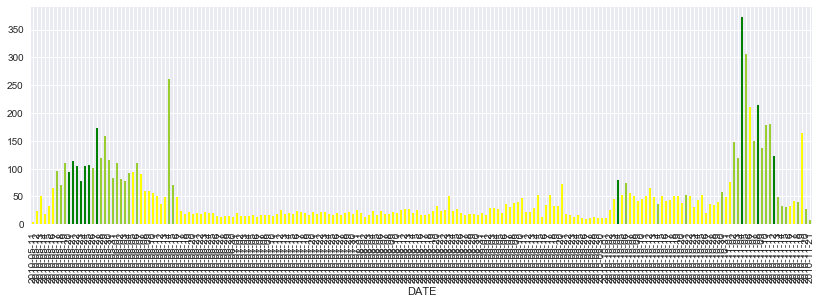

In [14]:
colors = {0: 'green', 1: 'yellowgreen', 2: 'yellow'}
daily['depth_change'].plot(kind='bar', color=[colors[i] for i in daily['Tidal activity level']], figsize=(14,4))

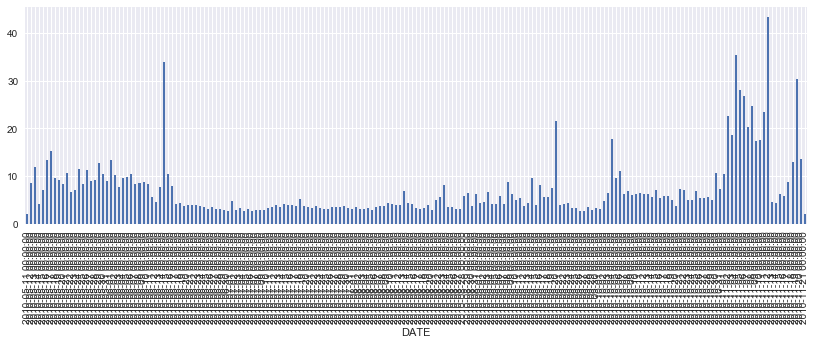

In [20]:
(data['depth'].resample('D').max() - data['depth'].resample('D').min()).plot(kind='bar',figsize=(14,4))